In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from LSTM import splitting_to_tensor
from LSTM import splitting_tr_te
from LSTM import LSTM
from LSTM import train_LSTM

sns.set()


In [3]:
data = pd.read_csv("../data/100portfolioReturns.csv", index_col=0)
data = data.dropna()
data.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,return
2012-04-02 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-04-03 00:00:00,-0.007446,-0.005276,-0.003327,-0.003998,-0.004997,-0.002600,-0.004703,-0.006392,-0.002469,-0.008691,...,-0.001224,-0.001968,-0.006162,-0.002358,-0.003388,-0.004309,-0.009976,-0.003208,-0.005690,-0.003989
2012-04-04 00:00:00,-0.016311,-0.011805,-0.014316,-0.010425,-0.012191,-0.014013,-0.011545,-0.016360,-0.011443,-0.014566,...,-0.010765,-0.011257,-0.013789,-0.009558,-0.009170,-0.011063,-0.019043,-0.009759,-0.015222,-0.014150
2012-04-05 00:00:00,-0.019330,-0.014877,-0.012136,-0.013979,-0.011770,-0.011771,-0.010776,-0.018710,-0.013322,-0.014644,...,-0.007452,-0.011277,-0.014654,-0.010360,-0.010234,-0.009119,-0.020947,-0.006877,-0.015974,-0.014771
2012-04-09 00:00:00,-0.031573,-0.026465,-0.023117,-0.024117,-0.023724,-0.024937,-0.022501,-0.029633,-0.023794,-0.026331,...,-0.018200,-0.020261,-0.023815,-0.019523,-0.020336,-0.020080,-0.033850,-0.018209,-0.024500,-0.025961


In [4]:
train_data, test_data = splitting_tr_te(data)
train_input, train_target, test_input, test_target = splitting_to_tensor(train_data)

print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

torch.Size([98, 2263])
torch.Size([98, 2263])
torch.Size([3, 2263])
torch.Size([3, 2263])


In [5]:
model = LSTM().float()
criterion = nn.MSELoss()
optimizer  = optim.LBFGS(model.parameters(), lr=0.6, max_iter=3)

In [6]:
# def train_LSTM(train_input, train_target, test_input, test_target, epochs=10):

#     for epoch in range(epochs):
#         print("Step:", epoch)

#         def closure():
#             optimizer.zero_grad()
#             out = model(train_input.float())
#             loss = criterion(out, train_target.float())
#             print("Loss:", loss.item())
#             loss.backward()
#             return loss
#         optimizer.step(closure)

#         with torch.no_grad():
#             pred = model(test_input.float())
#             loss = criterion(pred, test_target.float())
#             print("Test Loss:", loss.item())
#     y = pred.detach().numpy()

#     return y, loss

preds, loss = train_LSTM(train_input, train_target, test_input, test_target, model=model, criterion=criterion, optimizer=optimizer)

Step: 0
Loss: 1.3387070894241333
Loss: 1.3031947612762451
Loss: 0.4640772342681885
Test Loss: 0.6380547285079956
Step: 1
Loss: 0.4640772342681885
Loss: 0.3859795033931732
Loss: 0.3817434310913086
Test Loss: 0.49295774102211
Step: 2
Loss: 0.3817434310913086
Loss: 0.36216431856155396
Loss: 0.32167428731918335
Test Loss: 0.3533039689064026
Step: 3
Loss: 0.32167428731918335
Loss: 0.2835691571235657
Loss: 9.798883438110352
Test Loss: 10.513710975646973
Step: 4
Loss: 9.798883438110352
Loss: 0.5571795105934143
Loss: 0.2589919865131378
Test Loss: 0.2771167457103729
Step: 5
Loss: 0.2589919865131378
Loss: 0.09979370981454849
Loss: 0.05738943815231323
Test Loss: 0.05821867287158966
Step: 6
Loss: 0.05738943815231323
Loss: 0.04633794724941254
Loss: 0.04358794167637825
Test Loss: 0.0472564660012722
Step: 7
Loss: 0.04358794167637825
Loss: 0.04281488060951233
Loss: 0.04243825376033783
Test Loss: 0.04737046733498573
Step: 8
Loss: 0.04243825376033783
Loss: 0.04202886298298836
Loss: 0.04135550186038017
T

In [17]:
b_model = LSTM().float()
b_criterion = nn.MSELoss()
b_optimizer  = optim.LBFGS(b_model.parameters(), lr=0.6, max_iter=3)


In [19]:
beta = pd.read_csv("../data/100portfolioBetas_v2.csv", index_col=0)
beta = beta.dropna()
train_beta, test_beta = splitting_tr_te(beta)
b_train_input, b_train_target, b_test_input, b_test_target = splitting_to_tensor(train_beta)

b_preds, b_loss = train_LSTM(b_train_input, b_train_target, b_test_input, b_test_target, model=b_model, criterion=b_criterion, optimizer=b_optimizer)


Step: 0
Loss: 1.6283752918243408
Loss: 1.5818250179290771
Loss: 0.13024313747882843
Test Loss: 0.14806103706359863
Step: 1
Loss: 0.13024313747882843
Loss: 0.04811567813158035
Loss: 0.04800605773925781
Test Loss: 0.026510238647460938
Step: 2
Loss: 0.04800605773925781
Loss: 0.0477411262691021
Loss: 0.04705851152539253
Test Loss: 0.028377976268529892
Step: 3
Loss: 0.04705851152539253
Loss: 0.04549282789230347
Loss: 0.040212392807006836
Test Loss: 0.03154020383954048
Step: 4
Loss: 0.040212392807006836
Loss: 0.033036407083272934
Loss: 0.020530831068754196
Test Loss: 0.017488161101937294
Step: 5
Loss: 0.020530831068754196
Loss: 0.010924682021141052
Loss: 0.01048648077994585
Test Loss: 0.007494383957237005
Step: 6
Loss: 0.01048648077994585
Loss: 0.009845185093581676
Loss: 0.009782731533050537
Test Loss: 0.008153325878083706
Step: 7
Loss: 0.009782731533050537
Loss: 0.009776784107089043
Loss: 0.00974046066403389
Test Loss: 0.008197005838155746
Step: 8
Loss: 0.00974046066403389
Loss: 0.009461937

In [36]:
print(b_test_target.shape)
print(b_preds.shape)

torch.Size([3, 2263])
(3, 2263)


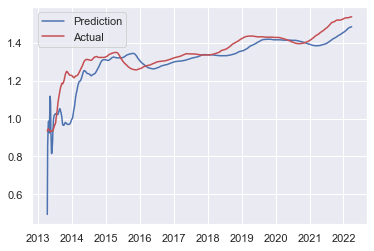

In [38]:
num = 1

plt.plot(dates[252:], b_preds[num], label="Prediction")
plt.plot(dates[252:], b_test_target[num], "r", label="Actual")
plt.legend()

plt.show()

In [39]:
testing = beta[["2", "55"]]
testing

,2,55
2012-04-03,0.834046,0.611010
2012-04-04,1.025418,1.000265
2012-04-05,0.917746,0.853249
2012-04-09,0.897146,0.809020
2012-04-10,0.920677,0.831909
...,...,...
2022-03-24,1.386565,1.946678
2022-03-25,1.386385,1.946455
2022-03-28,1.386213,1.946222
2022-03-29,1.386016,1.946001


In [40]:
future_preds = 126
transformed_testing = testing.T.to_numpy()
testing_input = torch.from_numpy(transformed_testing[:, :-future_preds])
testing_target = torch.from_numpy(transformed_testing[:, future_preds:])

In [41]:
dates = pd.to_datetime(testing.reset_index()["index"])
dates


0      2012-04-03
1      2012-04-04
2      2012-04-05
3      2012-04-09
4      2012-04-10
          ...    
2510   2022-03-24
2511   2022-03-25
2512   2022-03-28
2513   2022-03-29
2514   2022-03-30
Name: index, Length: 2515, dtype: datetime64[ns]

Test Loss: 0.010479758674991735


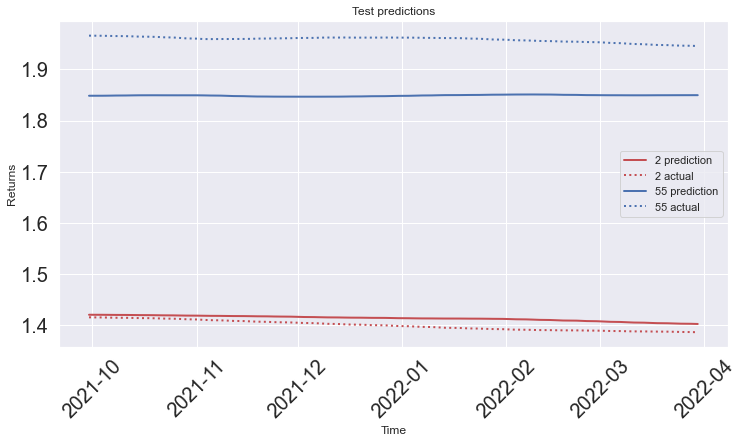

In [42]:
with torch.no_grad():
        pred = b_model(testing_input.float())
        loss = b_criterion(pred, testing_target)
        print("Test Loss:", loss.item())
        y = pred.detach().numpy()
        actuals = testing_target.detach().numpy()


plt.figure(figsize=(12, 6))
plt.title(f"Test predictions")
plt.xlabel("Time")
plt.ylabel("Returns")
plt.xticks(fontsize=20, rotation=45)
plt.yticks(fontsize=20)
n = testing_input.shape[1]
def draw(y_i, actuals, color, number):
        plt.plot(dates[-future_preds:], y_i[-future_preds:], color, linewidth=2.0, label=f"{testing.columns[number]} prediction")
        plt.plot(dates[-future_preds:], actuals[-future_preds:], color + ":", linewidth=2.0, label=f"{testing.columns[number]} actual")
draw(y[0], actuals[0], "r", number=0)
draw(y[1], actuals[1], "b", number=1)
plt.legend()

plt.show()